<a href="https://colab.research.google.com/github/hashPhoeNiX/ColabNotebooks/blob/master/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the dataset from [kaggle](https://www.kaggle.com/general/74235)

Steps:


1. Sign in to [kaggle](kaggle.com)

2. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download kaggle.json file on your machine.
3. Run the cells below.





In [ ]:
!pip install -q kaggle

In [ ]:
# Upload the kaggle.json file downloaded earlier

from google.colab import files
files.upload()

Saving kaggle(3).json to kaggle(3).json


{'kaggle(3).json': b'{"username":"hashphoenix","key":"a88e364663674fda8491a0361f34a80a"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:32<00:00, 64.5MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.4MB/s]


In [ ]:
ls

chest-xray-pneumonia.zip  kaggle.json  sample_data/


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

## Importing modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Data Augmentation

Image Augmentation is the process of generating new images for training our deep learning model. These new images are generated using the existing training images and hence we don’t have to collect them manually.

In [ ]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])
                                      ])
test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])
                                    ])

trainset = datasets.ImageFolder("./chest_xray/train", transform=train_transform)
validset = datasets.ImageFolder("./chest_xray/val", transform=test_transform)
testset = datasets.ImageFolder("./chest_xray/test", transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=True)

In [ ]:
len(trainset), len(validset), len(testset)

(5216, 16, 624)

## Visualisation

In [ ]:
# we get the class_to_index in the validation set to obtain cat_to_names
_ = validset.class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

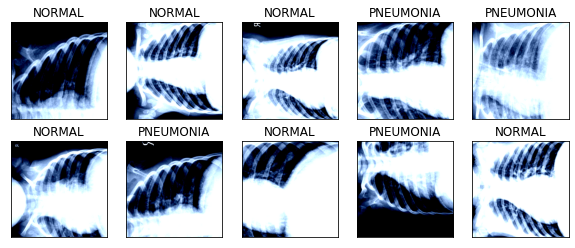

In [ ]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    # display 20 images
    for idx in np.arange(number_images):
        ax = fig.add_subplot(2, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        
showimage(validloader, 10, cat_to_name)

## Model Training

Using Transfer Learning.

In [ ]:
model = models.resnet18(pretrained=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2),
                         nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device

device(type='cuda')

In [ ]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 512])
torch.Size([2])


Creating an evaluation function to check the model accuracy on each dataloaders.

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return (100 * correct / total)

Training the model on the train dataloader and checking the performance on the validation set using cross validation technique.

In [ ]:
%%time

import time

n_epochs = 20
train_losses, val_losses = [], []
valid_loss_min = np.Inf 
start = time.time()
for epoch in range(1, n_epochs+1):
    #keeping track of valid and train losses
    train_loss = 0.0
    valid_loss = 0.0
    
    ############
    # Training #
    ############
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calculate loss
        loss = criterion(output, target)
        
        # backward pass
        loss.backward()
        
        # parameter update
        optimizer.step()
        
        # updating loss
        train_loss += loss.item()*data.size(0)
        
    ##############
    # Validation #
    ##############
    model.eval()
    accuracy = 0
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        ps = torch.exp(output).data
        valid_loss += loss.item()*data.size(0)
        equality = (target.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()
        
        
    # calculate average losses
    train_loss = train_loss /len(trainloader.dataset)
    valid_loss = valid_loss / len(validloader.dataset)
    accuracy = accuracy /len(validloader)
    
    # print train/valid loss 
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    print('Epoch: {} \tTraining loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    print("Accuracy: {:.4f}".format(accuracy))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        model.class_to_idx = trainset.class_to_idx
        checkpoint = {'architecture':'resnet18',
                      'classifier': model.fc,
                      'state_dict': model.state_dict(),
                      'class_to_idx': model.class_to_idx}
        
        # torch.save(model.state_dict(), 'model_classifier.pt')
        torch.save(checkpoint, 'model_classifier.pt')
        valid_loss_min = valid_loss
      
        
end = time.time()

print(f'Execution time: {(end-start)/60:.3f} mins')

Epoch: 1 	Training loss: 0.556539 	Validation Loss: 1.055007
Accuracy: 0.5000
Validation loss decreased (inf --> 1.055007). Saving model ...
Epoch: 2 	Training loss: 0.404033 	Validation Loss: 0.565230
Accuracy: 0.7500
Validation loss decreased (1.055007 --> 0.565230). Saving model ...
Epoch: 3 	Training loss: 0.433065 	Validation Loss: 0.760877
Accuracy: 0.6250
Epoch: 4 	Training loss: 0.474473 	Validation Loss: 1.219335
Accuracy: 0.5625
Epoch: 5 	Training loss: 0.405526 	Validation Loss: 0.801424
Accuracy: 0.5625
Epoch: 6 	Training loss: 0.388869 	Validation Loss: 1.173901
Accuracy: 0.5625
Epoch: 7 	Training loss: 0.436433 	Validation Loss: 2.435828
Accuracy: 0.5000
Epoch: 8 	Training loss: 0.403971 	Validation Loss: 1.197991
Accuracy: 0.6250
Epoch: 9 	Training loss: 0.425561 	Validation Loss: 1.611561
Accuracy: 0.5000
Epoch: 10 	Training loss: 0.399141 	Validation Loss: 0.799667
Accuracy: 0.5000
Epoch: 11 	Training loss: 0.381787 	Validation Loss: 0.958268
Accuracy: 0.5625
Epoch: 12

In [ ]:
## Loading the saved model

# checkpoint = torch.load('model_classifier.pt')

# model = models.resnet18(pretrained=False)

# model.class_to_idx = checkpoint['class_to_idx']
# model.load_state_dict(checkpoint['state_dict'])

## Model Evaluation

Check the accuracy of the model on the training, validation and test set

In [ ]:
# Model evaluation on the training and validation set

print("Accuracy on training set is {:.2f} and validation set is {:.2f}".format(evaluation(trainloader, model),evaluation(validloader, model)))

Accuracy on training set is 85.20 and validation set is 56.25


In [ ]:
# Model evaluation on the test set

print("Accuracy on test set is {:.2f}".format(evaluation(testloader, model)))

Accuracy on test set is 78.04


Visualising the training and validation losses

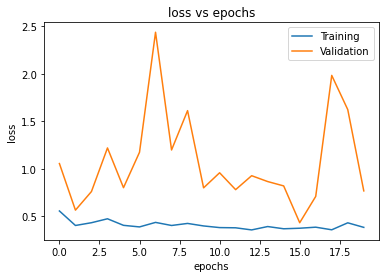

In [ ]:
plt.figure()

plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss vs epochs")
plt.legend()
plt.show()